# Hyperparamters Tuning using optuna

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [42]:
# set random seeds for reproducibility
torch.manual_seed(42)

In [43]:
# check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device:{device}")

using device:cuda


In [44]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df.shape

(60000, 785)

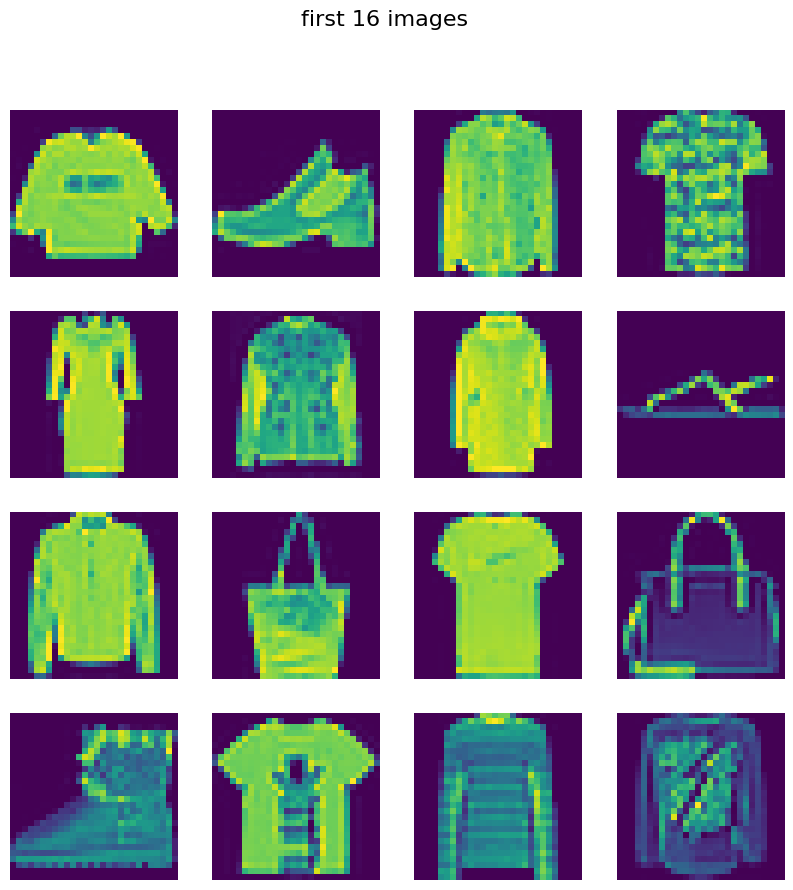

In [46]:
# create a 4x4 grid of images

fig, axes = plt.subplots(4,4,figsize= (10,10))
fig.suptitle('first 16 images', fontsize=16)

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

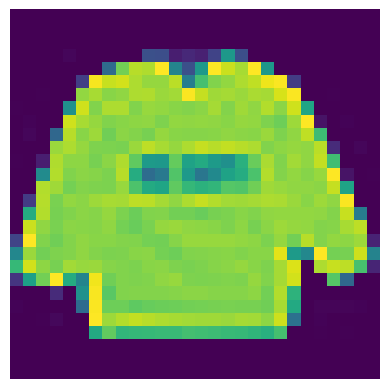

In [47]:
img = df.iloc[0,1:].values.reshape(28,28)
plt.plot(4,4)
plt.imshow(img)
plt.axis('off')

In [48]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:

X_train = X_train/255.0
X_test = X_test/255.0

In [50]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [51]:
train_dataset = CustomDataset(X_train, y_train)

In [52]:
test_dataset = CustomDataset(X_test, y_test)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Hyperparamter(no of layers and neurons per layer) are tuned

In [59]:
class MyNN(nn.Module):

  def __init__(self, input_dim , output_dim, num_hidden_layers, neuron_per_layer):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neuron_per_layer))
      layers.append(nn.BatchNorm1d(neuron_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neuron_per_layer

    layers.append(nn.Linear(neuron_per_layer, output_dim))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [60]:
# objectice function
# no of hidden layer
# neurons per layer

def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int('num_hidden_layers',1,5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
  model = model.to(device)

  # params init
  learning_rate = 0.1
  epochs = 50

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  # trainig loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      output = model(batch_features)

      # loss
      loss = criterion(output, batch_labels)

      # backward passs
      optimizer.zero_grad()
      loss.backward()

      # update
      optimizer.step()

  #evaluation
  model.eval()

  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _,predicted = torch.max(outputs,1)

      total += batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [ ]:
!pip install optuna

In [61]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-05-05 11:54:39,885] A new study created in memory with name: no-name-a21f06ab-9af5-441b-94f8-ebb1b5f97960
[I 2025-05-05 11:57:20,993] Trial 0 finished with value: 0.8844166666666666 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 64}. Best is trial 0 with value: 0.8844166666666666.
[I 2025-05-05 12:01:04,578] Trial 1 finished with value: 0.8833333333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 64}. Best is trial 0 with value: 0.8844166666666666.
[I 2025-05-05 12:05:19,505] Trial 2 finished with value: 0.8524166666666667 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 32}. Best is trial 0 with value: 0.8844166666666666.
[I 2025-05-05 12:09:08,860] Trial 3 finished with value: 0.8915833333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 120}. Best is trial 3 with value: 0.8915833333333333.
[I 2025-05-05 12:11:48,274] Trial 4 finished with value: 0.8919166666666667 and parameters: {'num_hidden_layers': 2, 'neu

In [62]:
study.best_value

0.8919166666666667

In [63]:
study.best_params

{'num_hidden_layers': 2, 'neurons_per_layer': 112}

In [64]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

# Hyperparamters are tuned:
1. Number of Layers
2. Neurons per layer
3. Learning rate
4. Dropout rate
5. Optimizer
6. Batch size
7. Weight decay

In [53]:
class MyNN(nn.Module):

  def __init__(self, input_dim , output_dim, num_hidden_layers, neuron_per_layer,dropout_rate):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neuron_per_layer))
      layers.append(nn.BatchNorm1d(neuron_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neuron_per_layer

    layers.append(nn.Linear(neuron_per_layer, output_dim))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [54]:
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int('num_hidden_layers',1,5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int('epochs', 10, 50, step=10)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical('batch_size', [32,64,128])
  optimizer_name = trial.suggest_categorical('optimizer',['Adam',"SGD","RMSprop"])
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

  # dataloader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model = model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay )
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # trainig loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      output = model(batch_features)

      # loss
      loss = criterion(output, batch_labels)

      # backward passs
      optimizer.zero_grad()
      loss.backward()

      # update
      optimizer.step()

  #evaluation
  model.eval()

  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _,predicted = torch.max(outputs,1)

      total += batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [55]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-05-05 11:31:15,485] A new study created in memory with name: no-name-2b86447b-c35c-411d-904c-e864433df4bf
[I 2025-05-05 11:31:43,378] Trial 0 finished with value: 0.87575 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 128, 'epochs': 30, 'learning_rate': 2.4966116902912014e-05, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 3.199472921132496e-05}. Best is trial 0 with value: 0.87575.
[I 2025-05-05 11:35:21,300] Trial 1 finished with value: 0.4250833333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 16, 'epochs': 40, 'learning_rate': 4.850166070690434e-05, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.00011293773698808447}. Best is trial 0 with value: 0.87575.
[I 2025-05-05 11:35:50,394] Trial 2 finished with value: 0.86125 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 88, 'epochs': 10, 'learning_rate': 3.575841999536168e-05, 'dropout_rate': 0.2, 'batch_size': 64, 

In [56]:
study.best_value

0.88325

In [57]:
study.best_params

{'num_hidden_layers': 1,
 'neurons_per_layer': 120,
 'epochs': 40,
 'learning_rate': 0.051096676368871836,
 'dropout_rate': 0.1,
 'batch_size': 128,
 'optimizer': 'SGD',
 'weight_decay': 4.206365763029856e-05}

In [65]:
from optuna.visualization import plot_optimization_history, plot_slice
plot_optimization_history(study).show()

In [66]:
plot_slice(study).show()